# Ensemble Learning: Random Forest

## Regression

In [1]:
# Importing necessary libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub as kh
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

### Loading, Defining and Understanding the Data

In [3]:
path = kh.dataset_download("denkuznetz/taxi-price-prediction")
df = pd.read_csv(f'{path}/taxi_trip_pricing.csv')

In [4]:
df.head()

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,Morning,Weekday,3.0,Low,Clear,3.56,0.80,0.32,53.82,36.2624
1,47.59,Afternoon,Weekday,1.0,High,Clear,NaN,0.62,0.43,40.57,NaN
2,36.87,Evening,Weekend,1.0,High,Clear,2.70,1.21,0.15,37.27,52.9032
3,30.33,Evening,Weekday,4.0,Low,NaN,3.48,0.51,0.15,116.81,36.4698
4,NaN,Evening,Weekday,3.0,High,Clear,2.93,0.63,0.32,22.64,15.6180


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       950 non-null    float64
 1   Time_of_Day            950 non-null    object 
 2   Day_of_Week            950 non-null    object 
 3   Passenger_Count        950 non-null    float64
 4   Traffic_Conditions     950 non-null    object 
 5   Weather                950 non-null    object 
 6   Base_Fare              950 non-null    float64
 7   Per_Km_Rate            950 non-null    float64
 8   Per_Minute_Rate        950 non-null    float64
 9   Trip_Duration_Minutes  950 non-null    float64
 10  Trip_Price             951 non-null    float64
dtypes: float64(7), object(4)
memory usage: 86.1+ KB


In [6]:
df.isnull().sum()

Trip_Distance_km         50
Time_of_Day              50
Day_of_Week              50
Passenger_Count          50
Traffic_Conditions       50
Weather                  50
Base_Fare                50
Per_Km_Rate              50
Per_Minute_Rate          50
Trip_Duration_Minutes    50
Trip_Price               49
dtype: int64

In [7]:
df.describe()

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
count,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,951.000000
mean,27.070547,2.476842,3.502989,1.233316,0.292916,62.118116,56.874773
std,19.905300,1.102249,0.870162,0.429816,0.115592,32.154406,40.469791
min,1.230000,1.000000,2.010000,0.500000,0.100000,5.010000,6.126900
25%,12.632500,1.250000,2.730000,0.860000,0.190000,35.882500,33.742650
50%,25.830000,2.000000,3.520000,1.220000,0.290000,61.860000,50.074500
75%,38.405000,3.000000,4.260000,1.610000,0.390000,89.055000,69.099350
max,146.067047,4.000000,5.000000,2.000000,0.500000,119.840000,332.043689


### Visualizing the Data

In [8]:
conti_cols = ['Trip_Distance_km', 'Base_Fare', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Price']

array([[<Axes: title={'center': 'Trip_Distance_km'}>,
        <Axes: title={'center': 'Base_Fare'}>],
       [<Axes: title={'center': 'Per_Km_Rate'}>,
        <Axes: title={'center': 'Per_Minute_Rate'}>],
       [<Axes: title={'center': 'Trip_Duration_Minutes'}>,
        <Axes: title={'center': 'Trip_Price'}>]], dtype=object)

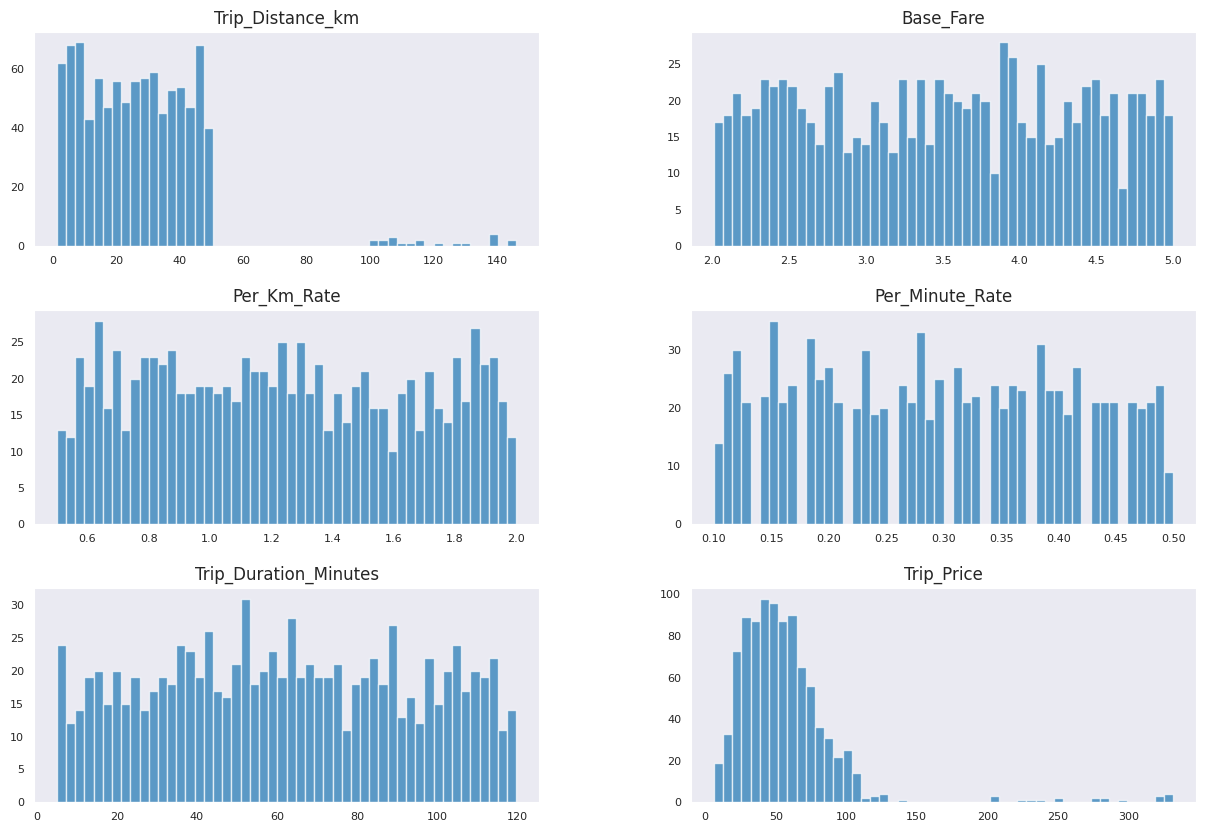

In [9]:
# Histogram
df[conti_cols].hist(figsize=(15, 10), bins=50, xlabelsize=8, ylabelsize=8, grid=False, alpha=0.7)

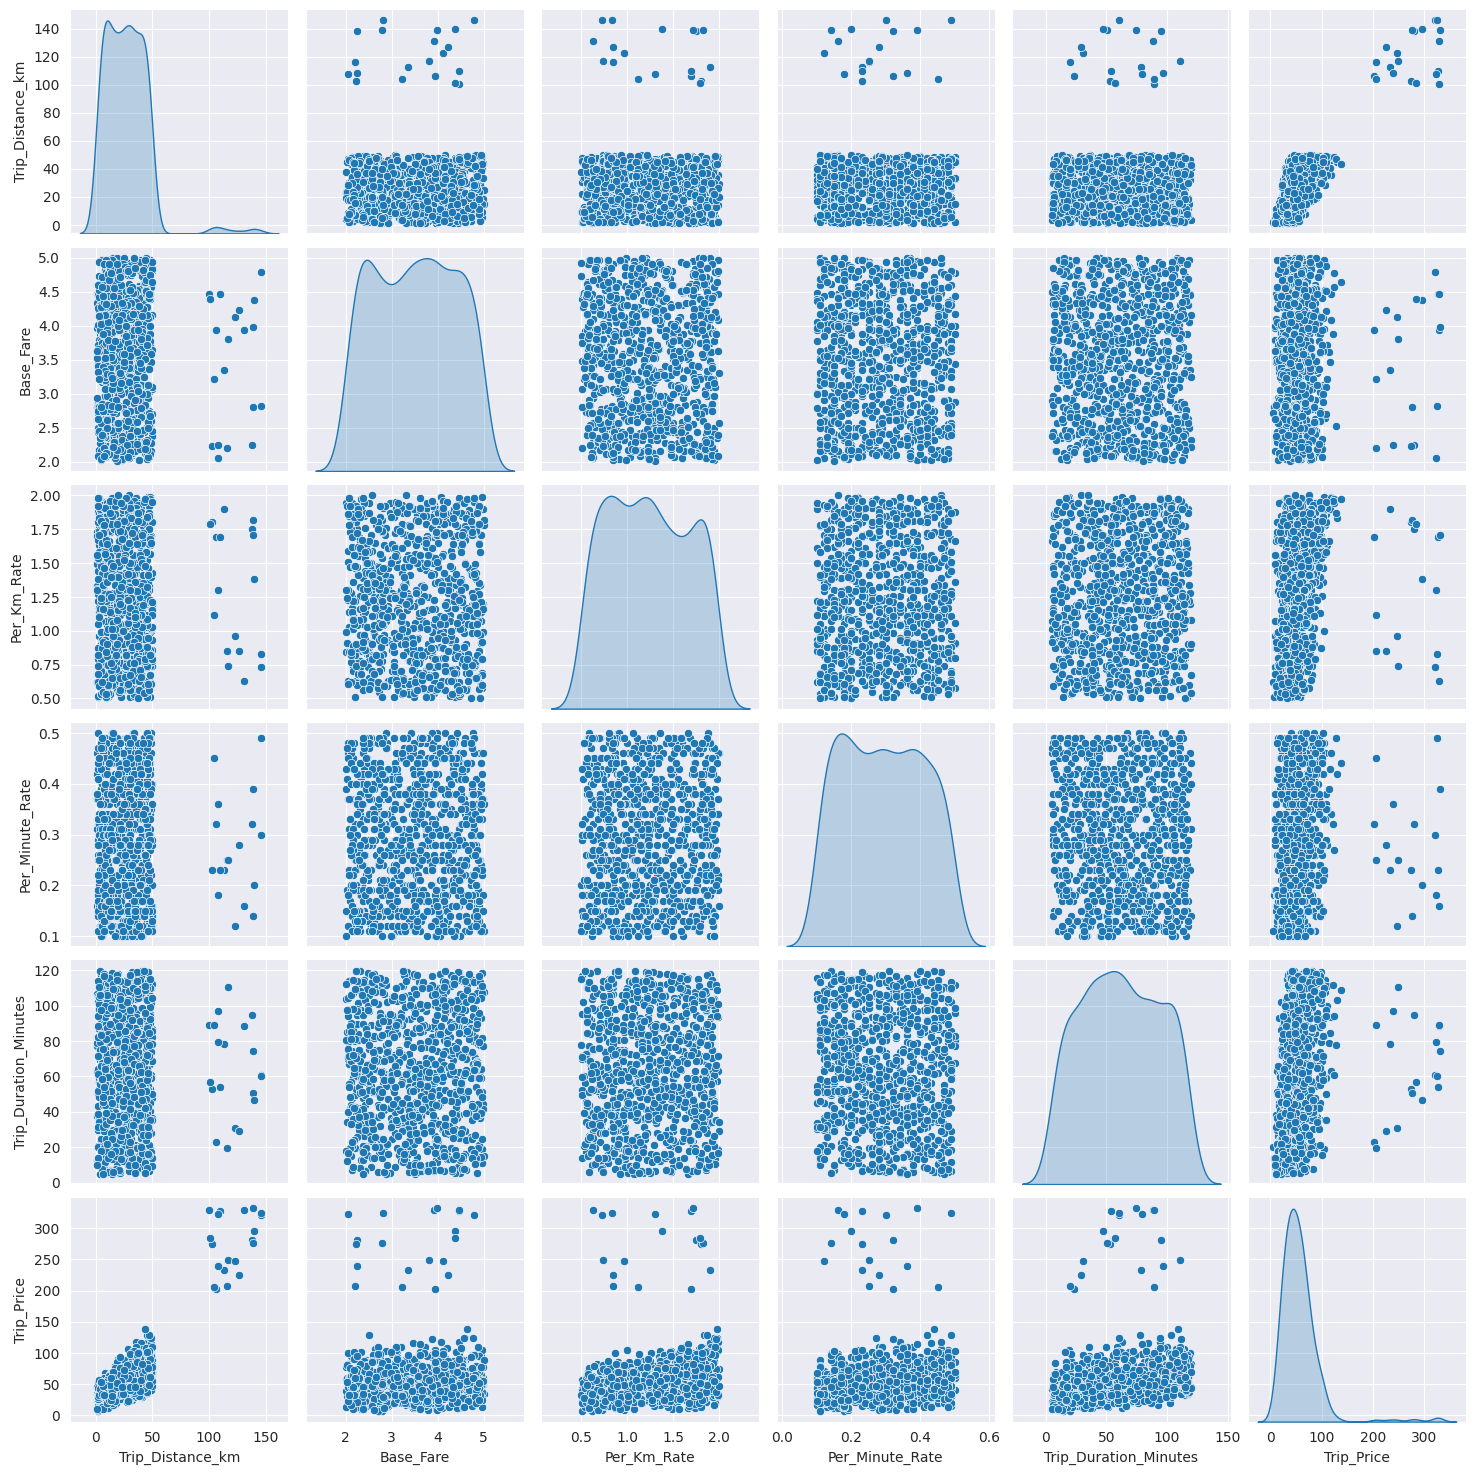

In [10]:
# Pairplot
sns.pairplot(df[conti_cols], diag_kind='kde')

<Axes: >

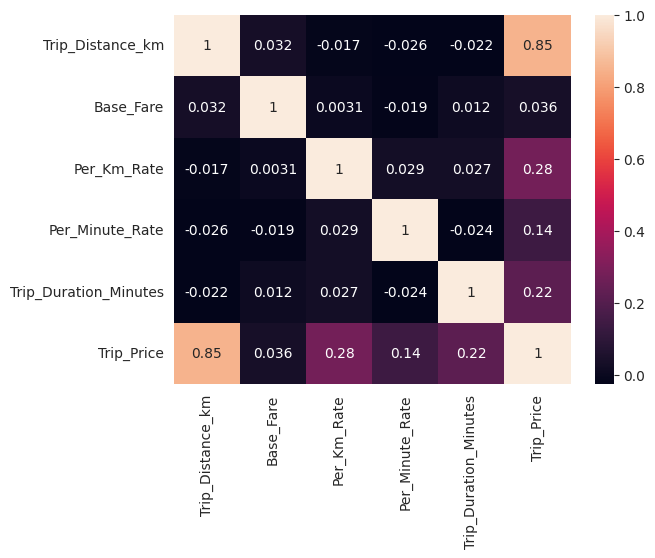

In [11]:
# Correlation
sns.heatmap(df[conti_cols].corr(), annot=True)

### Preprocessing: Pipeline

In [12]:
# Imputer of missing values
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

df[df.select_dtypes(include=[np.number]).columns] = num_imputer.fit_transform(df[df.select_dtypes(include=[np.number]).columns])
df[df.select_dtypes(include=[object]).columns] = cat_imputer.fit_transform(df[df.select_dtypes(include=[object]).columns])

In [13]:
df.isnull().sum()

Trip_Distance_km         0
Time_of_Day              0
Day_of_Week              0
Passenger_Count          0
Traffic_Conditions       0
Weather                  0
Base_Fare                0
Per_Km_Rate              0
Per_Minute_Rate          0
Trip_Duration_Minutes    0
Trip_Price               0
dtype: int64

In [14]:
# Splitting the dataset into X and y
X = df.drop('Trip_Price', axis=1)
y = df['Trip_Price']

In [15]:
# Splitting the dataset into num and cat
num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(include=[object]).columns

In [16]:
num_cols

Index(['Trip_Distance_km', 'Passenger_Count', 'Base_Fare', 'Per_Km_Rate',
       'Per_Minute_Rate', 'Trip_Duration_Minutes'],
      dtype='object')

In [17]:
# Preparing data to pipeline
num_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

In [18]:
# Combine the preprocessing steps
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

In [19]:
# Define the RandomForestRegressor with necessary hyperparameters
rf_regressor = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42
)

In [20]:
# Create the full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', rf_regressor)
])

### Training, Predicting and Evaluating the model

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Trip_Distance_km', 'Passenger_Count', 'Base_Fare', 'Per_Km_Rate',
       'Per_Minute_Rate', 'Trip_Duration_Minutes'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['Time_of_Day', 'Day_of_Week', 'Traffic_Conditions', 'Weather'], dtype='object'))])),
                ('regressor',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=4,
                                       min_samples_split=10, n_estimators=500,
                                       random_state=42))])

In [23]:
# Predict on the test set
y_pred = pipeline.predict(X_test)

In [24]:
# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"R2: {r2}")

RMSE: 7.8989024351952875
MSE: 62.39265968073404
R2: 0.9248610769724424


### Fine-Tuning: Randomized Search

In [34]:
# Define the parameter grid
param_grid = {
    'regressor__n_estimators': np.arange(100, 1000, 100),
    'regressor__max_depth': np.arange(1, 20, 1),
    'regressor__min_samples_split': np.arange(2, 20, 1),
    'regressor__min_samples_leaf': np.arange(1, 20, 1),
    'regressor__max_features': ['sqrt', 'log2', None]
}

In [26]:
# Define the RandomForestRegressor
rf_regressor_best = RandomForestRegressor(random_state=42)

In [27]:
# Create the full best pipeline
pipeline_best = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', rf_regressor_best)
])

In [35]:
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline_best,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42
)

In [36]:
# Fit the random search to the data
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['Trip_Distance_km', 'Passenger_Count', 'Base_Fare', 'Per_Km_Rate',
       'Per_Minute_Rate', 'Trip_Duration_Minutes'],
      dtype='object')),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_un...
                   param_distributions={'regressor__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'regressor__max_features': ['sqrt',
                                                                    'log2',
                                                                    None],
                                        'regressor__min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'regressor__min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                        'regressor__n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900])},
                   random_state=42, scoring='r2')

In [37]:
# Get the best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best R2 Score: {best_score}')

Best Parameters: {'regressor__n_estimators': np.int64(500), 'regressor__min_samples_split': np.int64(7), 'regressor__min_samples_leaf': np.int64(1), 'regressor__max_features': None, 'regressor__max_depth': np.int64(9)}
Best R2 Score: 0.9087107280500911


In [38]:
# Initialize the model with the best parameters
best_pipeline = random_search.best_estimator_
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Trip_Distance_km', 'Passenger_Count', 'Base_Fare', 'Per_Km_Rate',
       'Per_Minute_Rate', 'Trip_Duration_Minutes'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['Time_of_Day', 'Day_of_Week', 'Traffic_Conditions', 'Weather'], dtype='object'))])),
                ('regressor',
                 RandomForestRegressor(max_depth=np.int64(9), max_features=None,
                                       min_samples_leaf=np.int64(1),
                                       min_samples_split=np.int64(7),
                                       n_estimators=np.int64(500),
                                       random_state=42))])

In [39]:
# Predict the target variable
y_pred_best = best_pipeline.predict(X_test)

In [40]:
# Evaluate the model
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Best RMSE: {rmse_best}")
print(f"Best MSE: {mse_best}")
print(f"Best R2: {r2_best}")

Best RMSE: 7.878199792631089
Best MSE: 62.066031972612535
Best R2: 0.9252544318052832


## Classification

### I cant found the dataset with given link, was deleted or something else. When tried to go with link got page not found